# Clustering Analysis of Traditional Alcoholic Beverages from Various Countries

**Abstract:**

Alcoholic beverages are among the most widely consumed drinks in the world. Each country has its own traditional alcoholic beverage, and the characteristics of these beverages are influenced by the country's geographical location. This research report aims to classify types of alcoholic beverages from 60 countries across the continents of Africa, America, Asia, and Europe. The study was conducted using the K-Means algorithm. To determine the optimal number of clusters, the elbow method and silhouette method were applied, resulting in an optimal value of k = 5 clusters.

- Cluster 0 consists of beverages made from basic ingredients.
- Cluster 1 includes beverages with coffee flavors or rum-based drinks.
- Cluster 2 comprises beverages made from grapes.
- Cluster 3 represents distilled alcoholic beverages.
- Cluster 4 consists of drinks made from a combination of various ingredients.

**Table of Contents:**
1. Import dataset
2. Corpus Loading
3. Corpus Processing
4. K-Means Clustering
5. Cluster Analysis

## 1. Import libraries and dataset

In [ ]:
!pip install Unidecode
!pip install geopandas

# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

## 2. Corpus Loading

We will use the Pandas library to read a CSV file containing beverages from each country listed in the file. The beverage information is sourced from websites, and many entries contain words with non-UTF-8 characters (typically place names and similar terms), so we will read the file using latin1 encoding.

Next, we will extract the Description column into a text list for our corpus.

In [ ]:
path_file = '/content/nationaldrink__6162001117_Bisma.csv'  # Replace with filepath
# read file with pandas
data = pd.read_csv(path_file)

In [ ]:
# Text data example
data.iloc[1,4]

'Waragi is comparable to gin, with a subtle flavor that’s easily overpowered when used in mixed drinks. The production of waragi is largely unregulated, causing an incident in 2010 in which 80 people died due to high levels of methanol.'

In [ ]:
data.shape

(60, 5)

In [ ]:
corpus = data['Deskripsi'].tolist()
corpus[4][0:447]

'“The word arak comes from the Arabic word ‘araq,’ meaning “sweat.”Arak is produced with grapes cultivated in the Mediterranean. The grapes are crushed and put into barrels with juice where they are left to ferment for three weeks. The end product is a milky white and is very similar to rakı in Turkey, or ouzo in Greece.'

## 3. Corpus Processing

### a. Stop Words and Stemming

The first step in *corpus processing* is data engineering using the **national_drink** dataset to build a robust model. To achieve this, all words that do not contribute to the semantic meaning of the text (such as non-English alphabet characters) will be removed, and the remaining words will be stored in their simplest form. This allows us to apply weighting functions to each word without introducing bias or outliers.  

There are several techniques to clean our corpus; among them, we will remove the most common words ([stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)) and apply [stemming](https://www.researchgate.net/figure/Stemming-process-Algorithms-of-stemming-methods-are-divided-into-three-parts-mixed_fig2_324685008), a technique that reduces words to their root form.  

The method that applies stemming and stop word removal is outlined below. Additionally, we will define a method to eliminate words shorter than 2 letters or longer than 21 letters to further refine our corpus.

In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

### b. The main corpus processing function.

A section back, at the exploration of our dataset, we noticed some words containg weird characters that should be removed. By using RegEx our main processing function will remove unknown ASCII symbols, especial chars, numbers, e-mails, URLs, etc (It's a bit of a overkill, I know). It also uses the auxiliary funcitions defined above.

In [ ]:
def processCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line

    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase

        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)

        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
language = 'english'
corpus = processCorpus(corpus, language)
corpus[1][::]

'waragi compar gin subtl flavor easili overpow mix drink product waragi larg unregul caus incid peopl die due high level methanol'

### c. Statistical Weighting of Words

Now we will apply the [TF-IDF](https://jmotif.github.io/sax-vsm_site/morea/algorithm/TFIDF.html) function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf=pd.DataFrame(data=X.toarray(),columns=vectorizer.get_feature_names_out())
final_df=tf_idf
print("{} rows".format(final_df.shape[0]))
#final_df.T.nlargest(5, 0)

60 rows


In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
palm,0.608494,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
wine,0.295484,0.0,0.0,0.0,0.0,0.0,0.0,0.203077,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
nsafufuo,0.240579,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
sour,0.240579,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
depend,0.218498,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.187406,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final_df

,abre,absorb,accompani,ad,add,adult,advis,agav,age,agua,...,world,worldwid,worm,worth,write,writer,year,yeast,young,zwack
0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.332633,0.000000,0.000000
3,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.164028,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.20125,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.20125,...,0.000000,0.000000,0.000000,0.20125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 4. K-Means

##### Function that runs the K-Means algorithm *max_k* times and returns a dictionary of each k result

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1)

        kmeans_results.update( {k : kmeans.fit(data)} )

    return kmeans_results

In [ ]:
# Running Kmeans from 1 to k
k = 5
kmeans_results = run_KMeans(k, final_df)

df = final_df.to_numpy()


In [ ]:
kmeans_results[3].labels_

array([0, 2, 2, 0, 1, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 2, 2, 0, 2, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 2, 1], dtype=int32)

In [ ]:
kmeans_results[2].inertia_

56.07977202595815

In [ ]:
final_df

In [ ]:
transposed_df  = final_df.transpose()

In [ ]:
transposed_df

#### Elbow method

The Elbow method is used to find the elbow in the elbow plot. The elbow is found when the dataset becomes flat or linear after applying the cluster analysis algorithm. The elbow plot shows the elbow at the point where the number of clusters starts increasing.

Text(0.5, 0, 'Number of clusters')

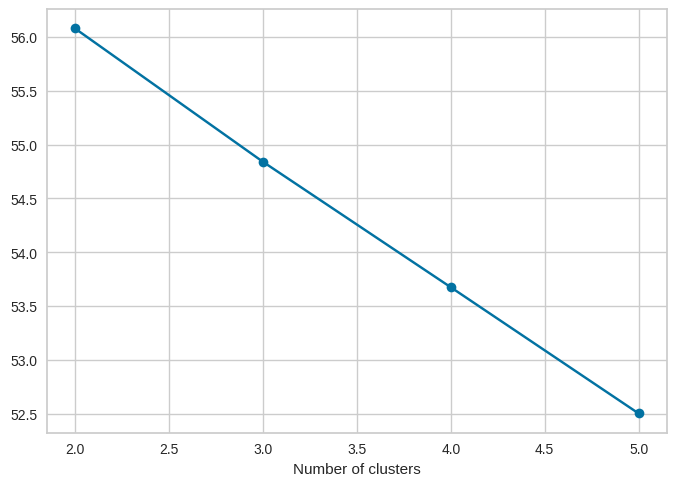

In [ ]:
distortions = []
for i in range(2,6):
  distortions.append(kmeans_results[i].inertia_)

plt.plot(range(2, 6), distortions, marker='o')
plt.xlabel('Number of clusters')

#### Silhouette Score

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [ ]:
avg_dict = dict()
for n_clusters, kmeans in kmeans_results.items():
  kmeans_labels = kmeans.predict(df)
  silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
  avg_dict.update( {silhouette_avg : n_clusters} )

Avg=[]
Ks=[]
for avg in sorted(avg_dict.keys(),reverse=True):
  Avg.append(avg.round(4))
  Ks.append(avg_dict[avg])

#kita simpan dalam tabel
silhouette_list=pd.DataFrame(
    {'K':Ks,
     'Average':Avg}
)
#tabel kita urutkan berdasarkan nilai K
silhouette_list=silhouette_list.sort_values(by=['K'])
silhouette_list

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,K,Average
1,2,0.0061
2,3,0.0056
3,4,0.0050
0,5,0.0067


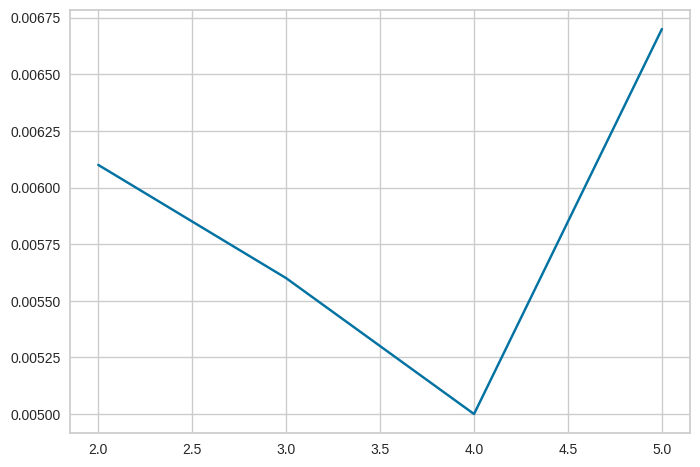

In [ ]:
#plot average
plt.plot(silhouette_list.K,silhouette_list.Average)
plt.show()

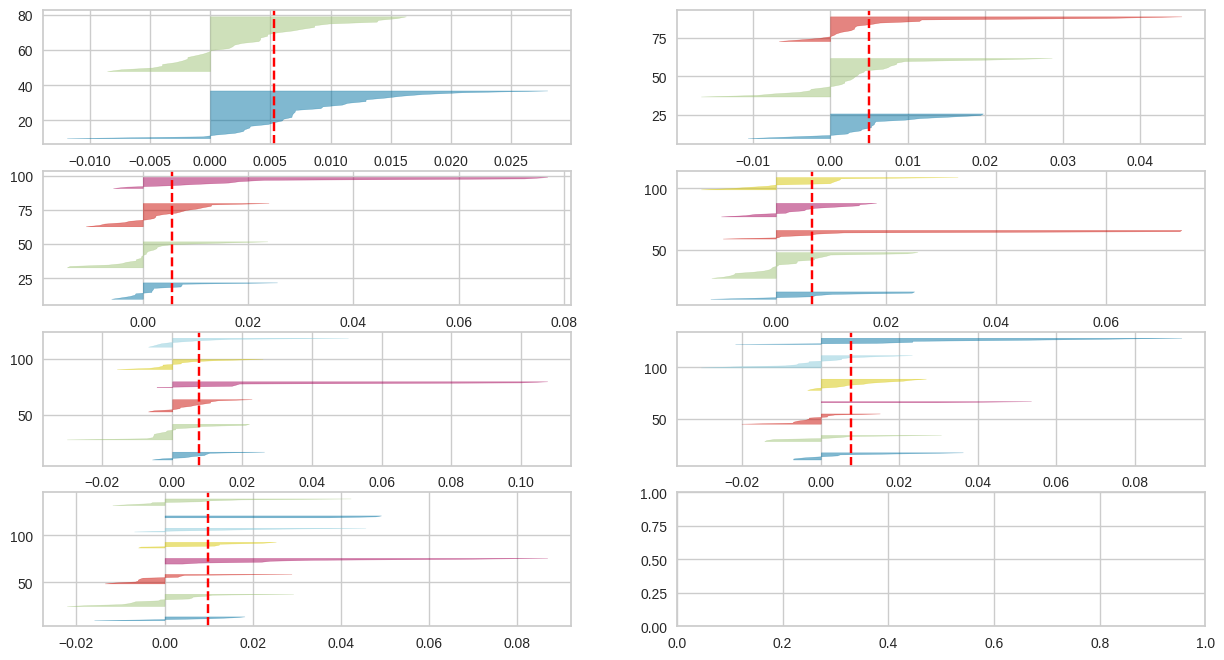

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in [2,3,4,5,6,7,8]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = cluster.KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer=SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df)

## 5. Cluster Analysis

Now we can choose the best number of K and take a deeper look at each cluster. Looking at the plots above, we have some clues that when K = 6 is when the clusters are best defined. So first we will use a simple histogram to look at the most dominant words in each cluster:

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

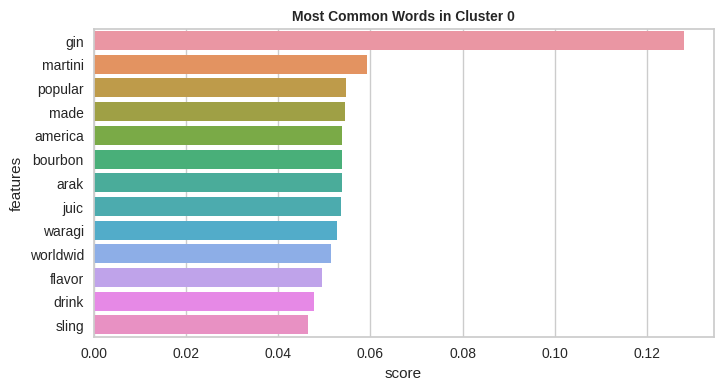

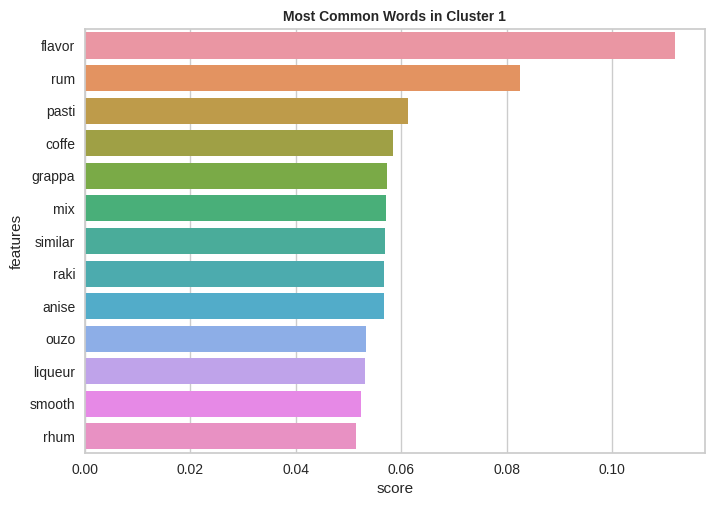

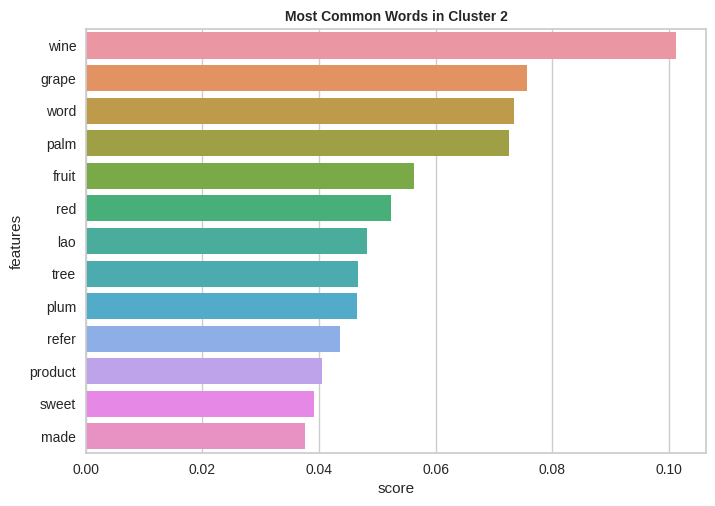

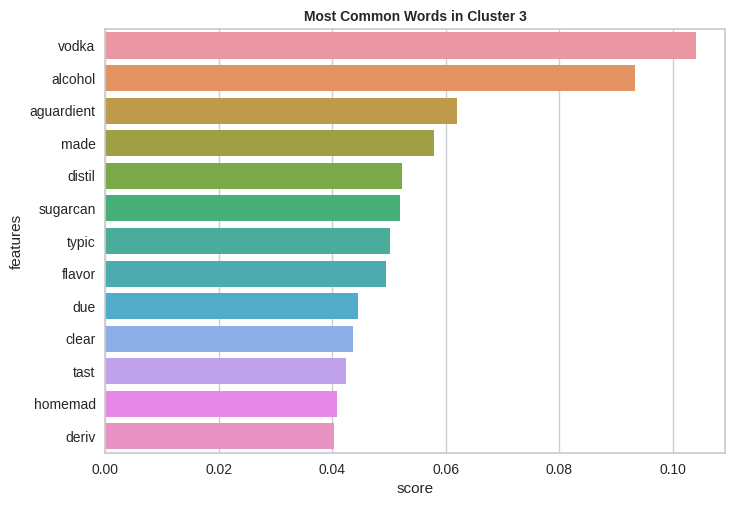

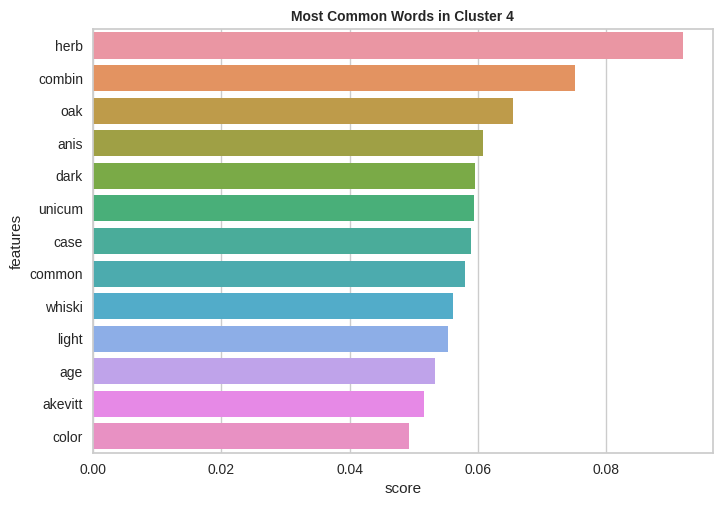

In [ ]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

#### Map of Words

Now that we can look at the graphs above and see the best scored words in each cluster, it's also interesting to make it prettier by making a map of words of each cluster!

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

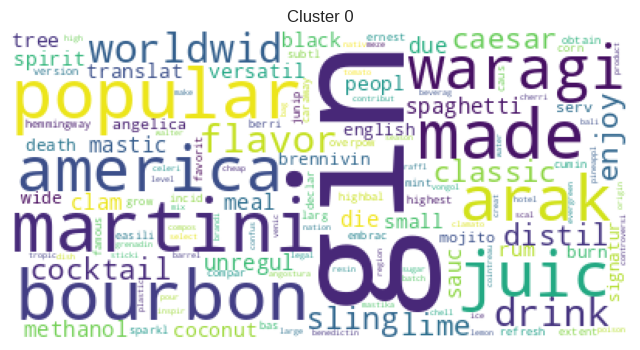

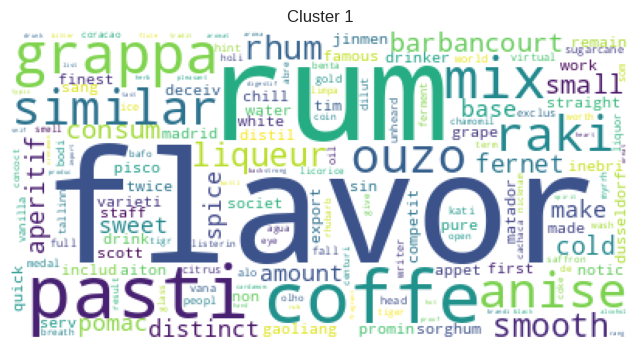

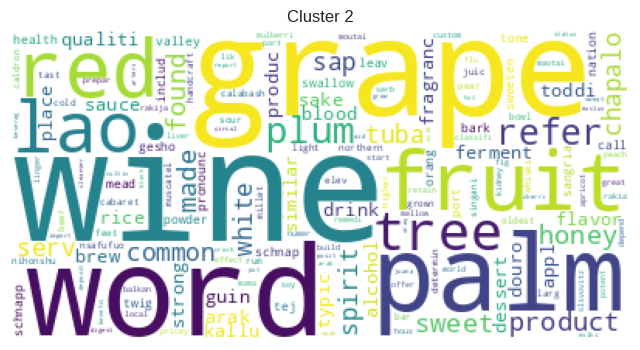

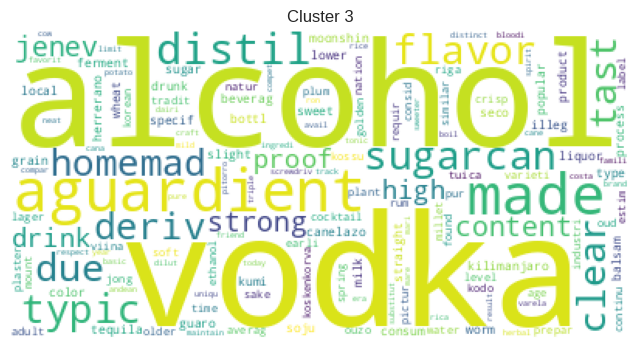

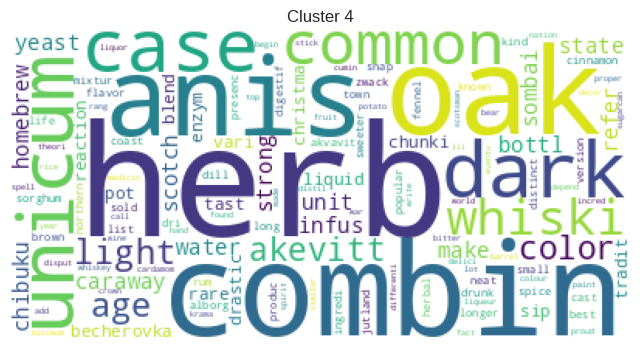

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns=final_df.columns
generateWordClouds(centroids)